In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm

In [2]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        
    def getVar(self, var):
        return np.asarray(self.ds[var])

In [3]:
# file  = "HS_front_RH50_PR0_PRRELAX86400_day0_500_all.dat"
file  = "HS_front_RH80_PR0_PRRELAX86400_with_w_all.dat"

ds = h5py.File(file, "r")
print(ds.keys())

print(np.nanmax(np.asarray(ds["grid_w_full_xyzt"])))
dycore = Dycore(file)
u  = dycore.getVar("grid_u_c_xyzt")
test = np.zeros(u.shape)
print(test.shape)

<KeysViewHDF5 ['_types', 'grid_geopots_xyzt', 'grid_lnp_full_xyzt', 'grid_lnp_half_xyzt', 'grid_lnps_xyzt', 'grid_p_full_xyzt', 'grid_p_half_xyzt', 'grid_ps_xyzt', 'grid_t_c_xyzt', 'grid_t_eq_xyzt', 'grid_tracers_c_xyz1t', 'grid_tracers_diff_xyz1t', 'grid_tracers_n_xyz1t', 'grid_tracers_p_xyz1t', 'grid_u_c_xyzt', 'grid_v_c_xyzt', 'grid_w_full_xyzt', 'grid_Δp_xyzt', 'spe_div_c_xyzt', 'spe_lnps_c_xyzt', 'spe_lnps_p_xyzt', 'spe_vor_c_xyzt']>
1.1106318184925956
(500, 20, 64, 128)


In [4]:
def plot_V_W_50(pr):
    file  = f"HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

    dycore = Dycore(file)
    # u  = dycore.getVar("grid_u_c_xyzt")
    v  = dycore.getVar("grid_v_c_xyzt")
    t  = dycore.getVar("grid_t_c_xyzt")
    ps = dycore.getVar("grid_ps_xyzt")
    p  = dycore.getVar("grid_p_full_xyzt")
    sigma = p / ps
    sigma_mean = np.nanmean(sigma, axis=(0,3))
    sigma_onlyz = np.nanmean(sigma_mean, axis=1)
    Rd = 287
    cp = 1004
    g = 9.81
    theta             = t * (ps / p)**(Rd/cp)
    H = 6800
    # p0 = 100000
    a = 6.37122e6
    
    # calculate rho_0 = exp(-Z/H) using Z = Hln(P0/P)
    # Z = H * np.log(np.nanmean(p0/p, axis=(0,3)))
    # Z_all     = H * np.log(p0/p)
    rho_0     = np.zeros((20,64))
    rho_0_all = np.zeros(u.shape)
    for i in range(0,20):
        rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
        rho_0_all[:,i,:,:] = p[:,i,:,:] / ps[:,0,:,:]                  # np.exp(-Z_all[:,i,:,:]/H) 
    omega  = (dycore.getVar("grid_w_full_xyzt"))
    w = omega  
    ### do dz by dz = H * ln(ps/p)
    THzmtm = np.nanmean(theta, axis=(0,3))
    THETAz  = np.zeros((20,64))
    p_onlyz = np.nanmean(p, axis=(0,2,3))
    for i in range(1,19):
        THETAz[i,:] = (THzmtm[i+1,:] - THzmtm[i-1,:]) / (p_onlyz[i+1] - p_onlyz[i-1])
    THETAz[0,:]  = (THzmtm[1,:]  - THzmtm[0,:])  /  (p_onlyz[1] - p_onlyz[0])
    THETAz[-1,:] = (THzmtm[-1,:] - THzmtm[-2,:]) /  (p_onlyz[-1] - p_onlyz[-2])
    
    THETAz[THETAz == 0] = np.nan # just in cast divide by zero 
    
    Vza = np.zeros(u.shape)
    THETAza = np.zeros(u.shape)
    Wza = np.zeros(u.shape)
    
    Vzm = np.nanmean(v, axis=3)
    THzm = np.nanmean(theta, axis=3)
    for i in range(128-1,0,-1):
        Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
        THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
        
    VTHETA = Vza * THETAza
    VTHzm = np.nanmean(VTHETA, axis=3)  ### mean lon
    VTHzmtm = np.nanmean(VTHzm, axis=0) ### mean time
    
    Wzm = np.nanmean(w, axis=3)
    Wzmtm = np.nanmean(Wzm, axis=0)
    Vzmtm = np.nanmean(v, axis=(0,3))
    
    # phi
    lat   = np.linspace(-90, 90, 64)
    phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
    lat_new = np.broadcast_to(lat.reshape(1,64),(20,64)) # Get latitude in radians
    
    cphi  = np.cos(phi) 
    acphi = a * cphi

    # calculate vTEM = v - 1/rho0 d/dz(rho0 v'Th'/THz)    
    vTEM_temp = rho_0 * VTHzmtm / THETAz
    vTEM_tempdz = np.zeros((20,64))
    for i in range(1,19):
        vTEM_tempdz[i,:] = (vTEM_temp[i+1,:] - vTEM_temp[i-1,:]) /  (p_onlyz[i+1] - p_onlyz[i-1])
    vTEM_tempdz[0,:]  = (vTEM_temp[1,:]  - vTEM_temp[0,:]) /  (p_onlyz[1] - p_onlyz[0])
    vTEM_tempdz[-1,:] = (vTEM_temp[-1,:] - vTEM_temp[-2,:]) / (p_onlyz[-1] - p_onlyz[-2])
    
    vTEM1 = Vzmtm
    vTEM2 = (1/rho_0) * vTEM_tempdz
    vTEM  = vTEM1 - vTEM2
    # calculate wTEM = w + 1/(acosphi) d/d(phi) (cosphi v'TH'/THz)
    wTEM_temp =  cphi * VTHzmtm / THETAz
    wTEM_tempdphi = np.zeros((20,64))
    for i in range(1,63):
        wTEM_tempdphi[:,i] = (wTEM_temp[:,i+1] - wTEM_temp[:,i-1]) / (phi[:,i+1] - phi[:,i-1])
    wTEM_tempdphi[:,0]  = (wTEM_temp[:,1] - wTEM_temp[:,0]) /  (phi[:,1]  - phi[:,0])
    wTEM_tempdphi[:,-1] = (wTEM_temp[:,-1] - wTEM_temp[:,-2]) / (phi[:,-1] - phi[:,-2])
    
    wTEM1 = Wzmtm
    wTEM2 = (wTEM_tempdphi) /acphi
    wTEM = wTEM1 + wTEM2

    return vTEM,wTEM,p, ps, Wzmtm, rho_0

In [5]:
def plot_V_W_80(pr):
    file  = f"HS_front_RH80_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

    dycore = Dycore(file)
    # u  = dycore.getVar("grid_u_c_xyzt")
    v  = dycore.getVar("grid_v_c_xyzt")
    t  = dycore.getVar("grid_t_c_xyzt")
    ps = dycore.getVar("grid_ps_xyzt")
    p  = dycore.getVar("grid_p_full_xyzt")
    sigma = p / ps
    sigma_mean = np.nanmean(sigma, axis=(0,3))
    sigma_onlyz = np.nanmean(sigma_mean, axis=1)
    Rd = 287
    cp = 1004
    g = 9.81
    theta             = t * (ps / p)**(Rd/cp)
    H = 6800
    # p0 = 100000
    a = 6.37122e6
    
    # calculate rho_0 = exp(-Z/H) using Z = Hln(P0/P)
    # Z = H * np.log(np.nanmean(p0/p, axis=(0,3)))
    # Z_all     = H * np.log(p0/p)
    rho_0     = np.zeros((20,64))
    rho_0_all = np.zeros(u.shape)
    for i in range(0,20):
        rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
        rho_0_all[:,i,:,:] = p[:,i,:,:] / ps[:,0,:,:]                  # np.exp(-Z_all[:,i,:,:]/H) 
    omega  = (dycore.getVar("grid_w_full_xyzt"))
    w = omega  
    ### do dz by dz = H * ln(ps/p)
    THzmtm = np.nanmean(theta, axis=(0,3))
    THETAz  = np.zeros((20,64))
    p_onlyz = np.nanmean(p, axis=(0,2,3))
    for i in range(1,19):
        THETAz[i,:] = (THzmtm[i+1,:] - THzmtm[i-1,:]) / (p_onlyz[i+1] - p_onlyz[i-1])
    THETAz[0,:]  = (THzmtm[1,:]  - THzmtm[0,:])  /  (p_onlyz[1] - p_onlyz[0])
    THETAz[-1,:] = (THzmtm[-1,:] - THzmtm[-2,:]) /  (p_onlyz[-1] - p_onlyz[-2])
    
    THETAz[THETAz == 0] = np.nan # just in cast divide by zero 
    
    Vza = np.zeros(u.shape)
    THETAza = np.zeros(u.shape)
    Wza = np.zeros(u.shape)
    
    Vzm = np.nanmean(v, axis=3)
    THzm = np.nanmean(theta, axis=3)
    for i in range(128-1,0,-1):
        Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
        THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
        
    VTHETA = Vza * THETAza
    VTHzm = np.nanmean(VTHETA, axis=3)  ### mean lon
    VTHzmtm = np.nanmean(VTHzm, axis=0) ### mean time
    
    Wzm = np.nanmean(w, axis=3)
    Wzmtm = np.nanmean(Wzm, axis=0)
    Vzmtm = np.nanmean(v, axis=(0,3))
    
    # phi
    lat   = np.linspace(-90, 90, 64)
    phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
    lat_new = np.broadcast_to(lat.reshape(1,64),(20,64)) # Get latitude in radians
    
    cphi  = np.cos(phi) 
    acphi = a * cphi

    # calculate vTEM = v - 1/rho0 d/dz(rho0 v'Th'/THz)    
    vTEM_temp = rho_0 * VTHzmtm / THETAz
    vTEM_tempdz = np.zeros((20,64))
    for i in range(1,19):
        vTEM_tempdz[i,:] = (vTEM_temp[i+1,:] - vTEM_temp[i-1,:]) /  (p_onlyz[i+1] - p_onlyz[i-1])
    vTEM_tempdz[0,:]  = (vTEM_temp[1,:]  - vTEM_temp[0,:]) /  (p_onlyz[1] - p_onlyz[0])
    vTEM_tempdz[-1,:] = (vTEM_temp[-1,:] - vTEM_temp[-2,:]) / (p_onlyz[-1] - p_onlyz[-2])
    
    vTEM1 = Vzmtm
    vTEM2 = (1/rho_0) * vTEM_tempdz
    vTEM  = vTEM1 - vTEM2
    # calculate wTEM = w + 1/(acosphi) d/d(phi) (cosphi v'TH'/THz)
    wTEM_temp =  cphi * VTHzmtm / THETAz
    wTEM_tempdphi = np.zeros((20,64))
    for i in range(1,63):
        wTEM_tempdphi[:,i] = (wTEM_temp[:,i+1] - wTEM_temp[:,i-1]) / (phi[:,i+1] - phi[:,i-1])
    wTEM_tempdphi[:,0]  = (wTEM_temp[:,1] - wTEM_temp[:,0]) /  (phi[:,1]  - phi[:,0])
    wTEM_tempdphi[:,-1] = (wTEM_temp[:,-1] - wTEM_temp[:,-2]) / (phi[:,-1] - phi[:,-2])
    
    wTEM1 = Wzmtm
    wTEM2 = (wTEM_tempdphi) /acphi
    wTEM = wTEM1 + wTEM2

    return vTEM,wTEM,p, ps, Wzmtm, rho_0

In [6]:
vTEM, wTEM,p, ps, Wzmtm, rho_0 = plot_V_W_80(0)

0
1
2
3
4
5


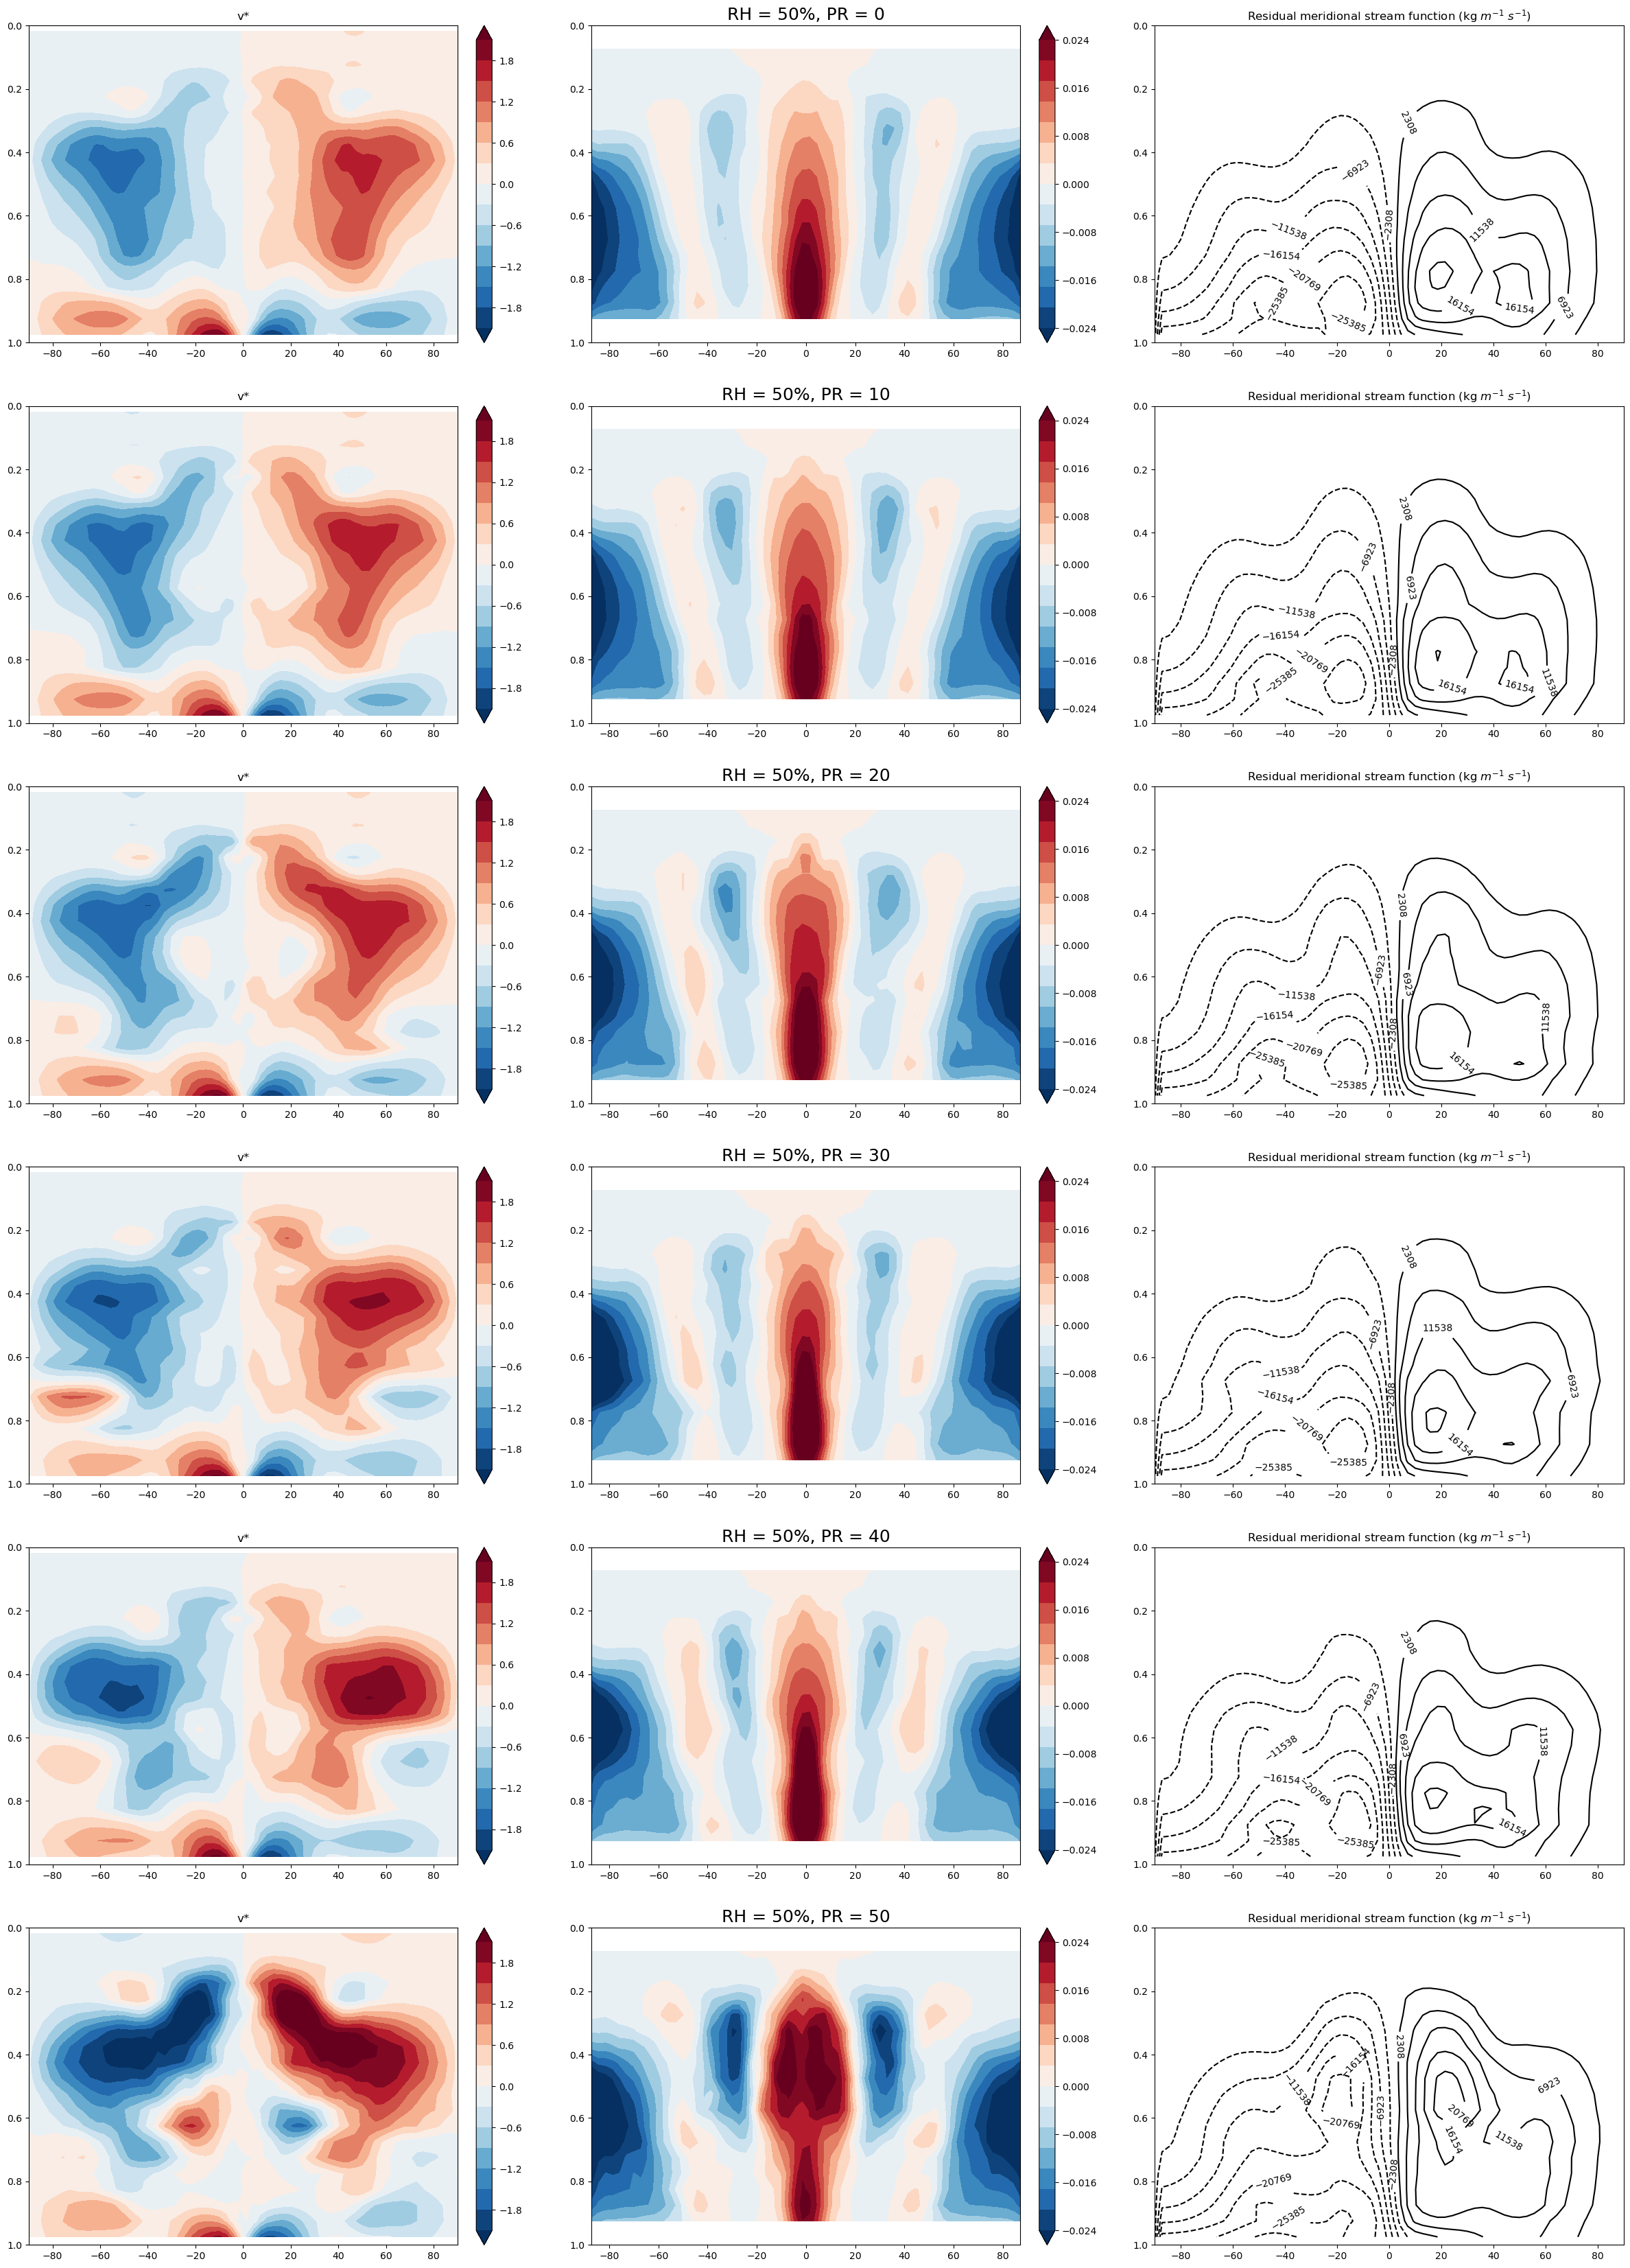

In [11]:
### plot RH = 50
import cmaps
fig, ax = plt.subplots(6, 3, figsize=(30, 42))
for pr in range(0,60,10):
    vTEM, wTEM,p, ps, Wzmtm, rho_0 = plot_V_W_50(pr)
    sigma_mean = np.nanmean(p/ps, axis=(0,3))
    sigma_onlyz = np.nanmean(sigma_mean, axis=1)
    y = np.linspace(-90,90,64)
    yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
    ### residual circulation
    # phi
    a = 6.37122e6
    lat   = np.linspace(-90, 90, 64)
    phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
    cphi  = np.cos(phi) 
    acphi = a * cphi

    psi_w1 = Wzmtm #np.nanmean(w , axis=(0,3))
    psi_w2 = Wzmtm #np.nanmean(w , axis=(0,3))

    psi_w1[:,0] = 0
    for ilat in range(1,64-1):
        dlat = phi[:,ilat] - phi[:,ilat-1]       
        psi_w1[:,ilat] =  psi_w1[:,ilat-1] + (dlat * rho_0[:,ilat] * acphi[:,ilat] * (wTEM)[:,ilat])
        # print(psi_w1[:,ilat])

    psi_w2[:,64-1] = 0    
    for jlat in range(1,64-1):
        ilat = 64 - 1 - jlat
        dlat = phi[:,ilat] - phi[:,ilat+1]           
        psi_w2[:,ilat] =  psi_w2[:,ilat+1] + (dlat * rho_0[:,ilat] * acphi[:,ilat] * (wTEM)[:,ilat])

    psi_w = 0.5*(psi_w1 + psi_w2)
    ####

    # plot
    print(int(pr/10))
    ### v*
    cs1 = ax[int(pr/10),0].contourf(yy[:,:], sigma_mean2[:,:], vTEM[:,:], levels=np.linspace(-2.1,2.1,15), cmap="RdBu_r", extend="both")
    ax[int(pr/10),0].set_ylim([1,0])
    fig.colorbar(cs1, orientation='vertical', ax=ax[int(pr/10),0],fraction=0.046, pad=0.04)
    ax[int(pr/10),0].set_title("v*")
    ###. w*
    cs2 = ax[int(pr/10),1].contourf(yy[1:-1,1:-1], sigma_mean2[1:-1,1:-1],-wTEM[1:-1,1:-1], levels=np.linspace(-2.4E-2,2.4E-2,15), cmap="RdBu_r", extend="both")
    ax[int(pr/10),1].set_ylim([1,0])
    cb2 = fig.colorbar(cs2, orientation='vertical', ax=ax[int(pr/10),1],fraction=0.046, pad=0.04)
    cb2.set_ticks(np.linspace(-2.4E-2,2.4E-2,7))
    ax[int(pr/10),1].set_title("w*")
    ### plot residual
    cs3 = ax[int(pr/10),2].contour(yy,sigma_mean2, -psi_w, levels=np.linspace(-30000,30000,14), colors='k')
    # print(np.nanmax(psi_w), np.nanmin(psi_w))
    ax[int(pr/10),2].clabel(cs3)
    ax[int(pr/10),2].set_ylim([1,0])
    ax[int(pr/10),2].set_title("Residual meridional stream function (kg $m^{-1}$ $s^{-1}$)") #(kg $m^{-1}$ $s^{-1}$) (RH=50, PR=10)
    ax[int(pr/10),1].set_title(f"RH = 50%, PR = {pr}", fontsize=18)
# plt.savefig(r"paper1_fig/TEM_v*_w*//plot_RH50_PR0_50_TEM.png", dpi=600., bbox_inches='tight')
plt.show()

0
1
2
3
4
5


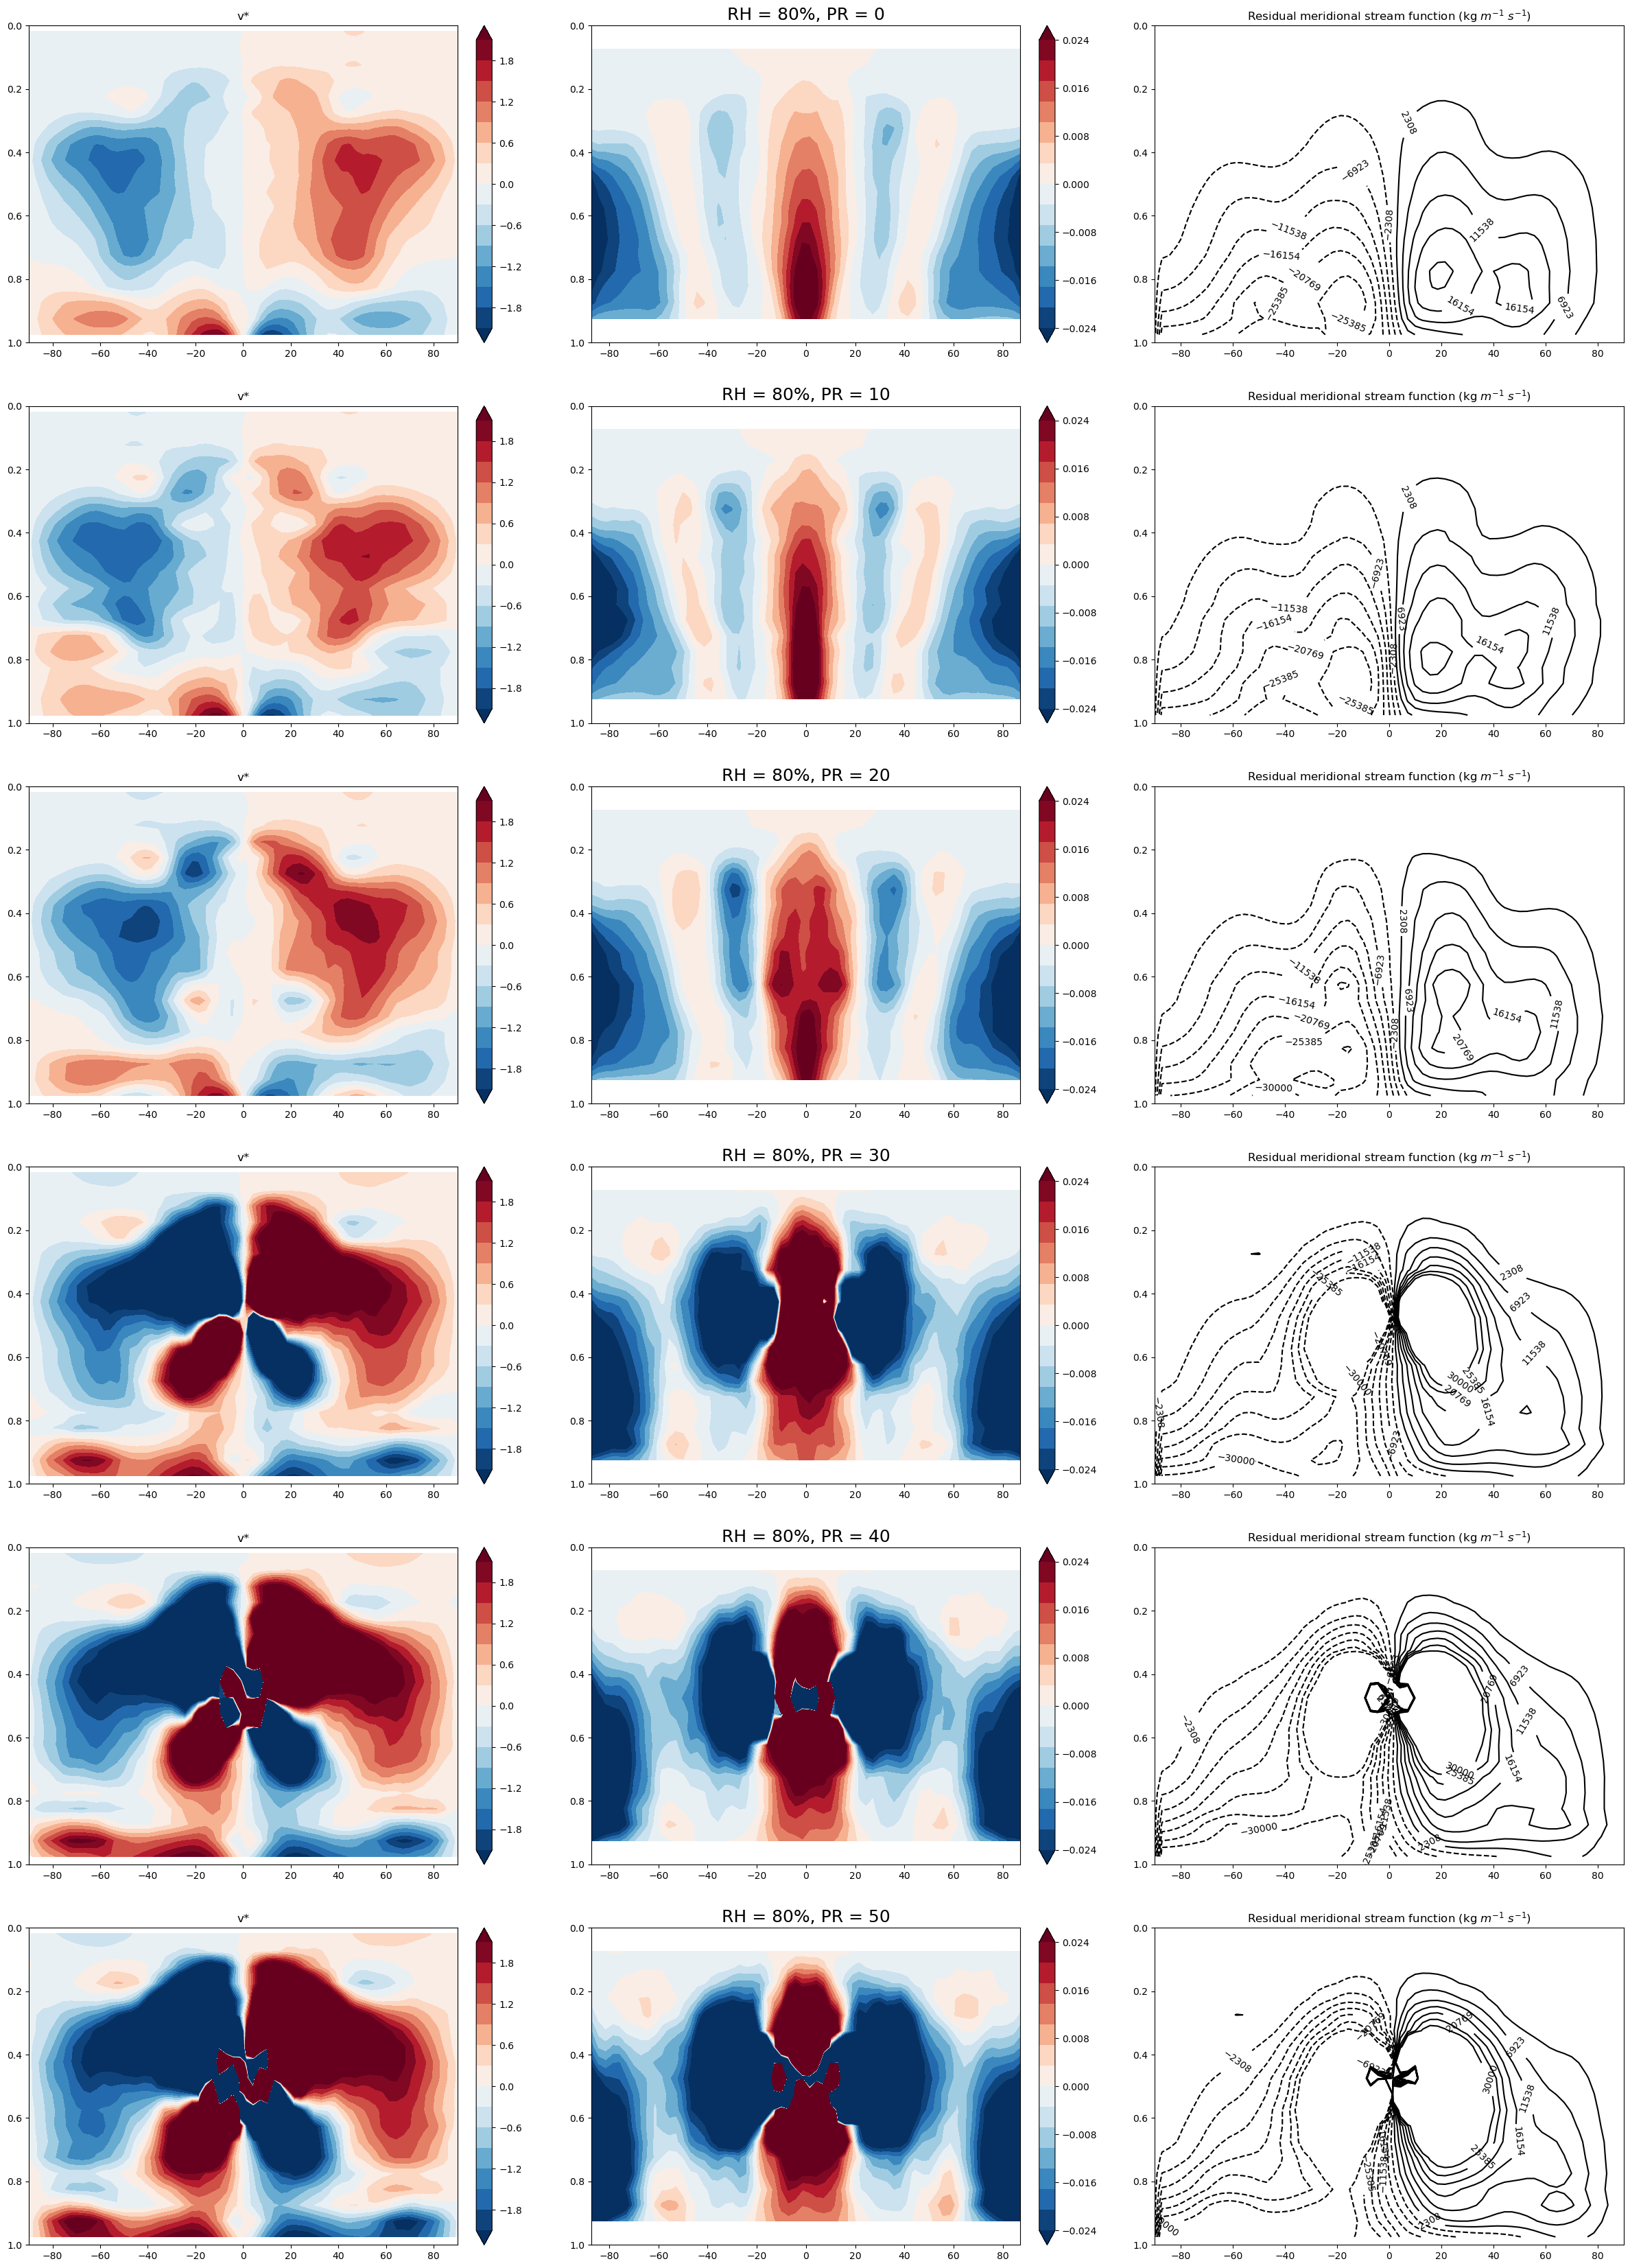

In [12]:
### plot RH=80
import cmaps
fig, ax = plt.subplots(6, 3, figsize=(30, 42))
for pr in range(0,60,10):
    vTEM, wTEM,p, ps, Wzmtm, rho_0 = plot_V_W_80(pr)
    sigma_mean = np.nanmean(p/ps, axis=(0,3))
    sigma_onlyz = np.nanmean(sigma_mean, axis=1)
    y = np.linspace(-90,90,64)
    yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
    ### residual circulation
    # phi
    a = 6.37122e6
    lat   = np.linspace(-90, 90, 64)
    phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
    cphi  = np.cos(phi) 
    acphi = a * cphi

    psi_w1 = Wzmtm #np.nanmean(w , axis=(0,3))
    psi_w2 = Wzmtm #np.nanmean(w , axis=(0,3))

    psi_w1[:,0] = 0
    for ilat in range(1,64-1):
        dlat = phi[:,ilat] - phi[:,ilat-1]       
        psi_w1[:,ilat] =  psi_w1[:,ilat-1] + (dlat * rho_0[:,ilat] * acphi[:,ilat] * (wTEM)[:,ilat])
        # print(psi_w1[:,ilat])

    psi_w2[:,64-1] = 0    
    for jlat in range(1,64-1):
        ilat = 64 - 1 - jlat
        dlat = phi[:,ilat] - phi[:,ilat+1]           
        psi_w2[:,ilat] =  psi_w2[:,ilat+1] + (dlat * rho_0[:,ilat] * acphi[:,ilat] * (wTEM)[:,ilat])

    psi_w = 0.5*(psi_w1 + psi_w2)
    ####

    # plot
    print(int(pr/10))
    ### v*
    cs1 = ax[int(pr/10),0].contourf(yy[:,:], sigma_mean2[:,:], vTEM[:,:], levels=np.linspace(-2.1,2.1,15), cmap="RdBu_r", extend="both")
    ax[int(pr/10),0].set_ylim([1,0])
    fig.colorbar(cs1, orientation='vertical', ax=ax[int(pr/10),0],fraction=0.046, pad=0.04)
    ax[int(pr/10),0].set_title("v*")
    ###. w*
    cs2 = ax[int(pr/10),1].contourf(yy[1:-1,1:-1], sigma_mean2[1:-1,1:-1],-wTEM[1:-1,1:-1], levels=np.linspace(-2.4E-2,2.4E-2,15), cmap="RdBu_r", extend="both")
    ax[int(pr/10),1].set_ylim([1,0])
    cb2 = fig.colorbar(cs2, orientation='vertical', ax=ax[int(pr/10),1],fraction=0.046, pad=0.04)
    cb2.set_ticks(np.linspace(-2.4E-2,2.4E-2,7))
    ax[int(pr/10),1].set_title("w*")
    ### plot residual
    cs3 = ax[int(pr/10),2].contour(yy,sigma_mean2, -psi_w, levels=np.linspace(-30000,30000,14), colors='k')
    # print(np.nanmax(psi_w), np.nanmin(psi_w))
    ax[int(pr/10),2].clabel(cs3)
    ax[int(pr/10),2].set_ylim([1,0])
    ax[int(pr/10),2].set_title("Residual meridional stream function (kg $m^{-1}$ $s^{-1}$)") #(kg $m^{-1}$ $s^{-1}$) (RH=50, PR=10)
    ax[int(pr/10),1].set_title(f"RH = 80%, PR = {pr}", fontsize=18)
# plt.savefig(r"paper1_fig/TEM_v*_w*//plot_RH80_PR0_50_TEM.png", dpi=600., bbox_inches='tight')
plt.show()

In [9]:
### try to calculate balanced partial u partial t, which is calculated by TEM equation.
# first calculate zonal (v'q') (q is potential vorticity)
v  = dycore.getVar("grid_v_c_xyzt")
u  = dycore.getVar("grid_u_c_xyzt")
p  = dycore.getVar("grid_p_full_xyzt")
ps = dycore.getVar("grid_ps_xyzt")
t  = dycore.getVar("grid_t_c_xyzt")
Rd = 287
cp = 1004

theta = t * (ps / p)**(Rd/cp)
x = np.linspace(-180,180,128)
y = np.linspace(-90,90,64)
xx = np.deg2rad(x)
yy = np.deg2rad(y)

Vza = np.zeros(u.shape)
Uza = np.zeros(u.shape)
THETAza = np.zeros(u.shape)
    
Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
THzm = np.nanmean(theta, axis=3)
for i in range(128-1,0,-1):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Vzm
    THETAza[:,:,:,i] = theta[:,:,:,i] - THzm

zeta = np.zeros(u.shape)
pvpx = np.zeros(u.shape) # mean partial v over partial x 
pupy = np.zeros(u.shape)
for i in range(0, 128-1):
    pvpx[:,:,:,i] = (Vza[:,:,:,i+1] - Vza[:,:,:,i-1]) / (xx[i+1] - xx[i-1])
pvpx[:,:,:,0]  = (Vza[:,:,:, 1] - Vza[:,:,:, 0]) / (xx[1] - xx[0])
pvpx[:,:,:,-1] = (Vza[:,:,:,-1] - Vza[:,:,:,-2]) / (xx[-1] - xx[-2])

for i in range(0, 64-1):
    pupy[:,:,i,:] = (Uza[:,:,i+1,:] - Uza[:,:,i-1,:]) / (yy[i+1] - yy[i-1])
pupy[:,:, 0,:] = (Uza[:,:, 1,:] - Uza[:,:, 0,:]) / (yy[1] - yy[0])
pupy[:,:,-1,:] = (Uza[:,:,-1,:] - Uza[:,:,-2,:]) / (yy[-1] - yy[-2])

zeta = pvpx - pupy

print(lat)
f0  = 2 * 7.292E-5 * np.sin(np.deg2rad(lat))
bza = THETAza / np.nanmean(theta) * 9.81

N_square   = np.zeros(u.shape)
for i in range(1,20-1):
    N_square[:,i,:,:]   = 9.81 / theta[:,i,:,:] * (theta[:,i+1,:,:] - theta[:,i-1,:,:]) / (p[:,i+1,:,:] - p[:,i-1,:,:]) # original is partial z, but Dycore is on pressure (sigma) coord. so add minus
N_square[:, 0,:,:] = 9.81 / theta[:, 0,:,:] * (theta[:, 1,:,:] - theta[:, 0,:,:]) / (p[:, 1,:,:] - p[:, 0,:,:])
N_square[:,-1,:,:] = 9.81 / theta[:,-1,:,:] * (theta[:,-1,:,:] - theta[:,-2,:,:]) / (p[:,-1,:,:] - p[:,-2,:,:])

q1 = zeta
q2 = np.zeros(u.shape)
for i in range(1,20-1):
    q2[:,i,:,:] = (bza[:,i+1,:,:] - bza[:,i-1,:,:]) / (N_square[:,i+1,:,:] - N_square[:,i-1,:,:]) / (p[:,i+1,:,:] - p[:,i-1,:,:]) 
q2[:,0,:,:]  = (bza[:, 1,:,:] - bza[:, 0,:,:]) / (N_square[:, 1,:,:] - N_square[:, 0,:,:]) / (p[:, 1,:,:] - p[:, 0,:,:]) 
q2[:,-1,:,:] = (bza[:,-1,:,:] - bza[:,-2,:,:]) / (N_square[:,-1,:,:] - N_square[:,-2,:,:]) / (p[:,-1,:,:] - p[:,-2,:,:]) 

for j in range(0, 64):
    q2[:,:,j,:] *= f0[j]

qza = q1 + q2

pupt = f0 * vTEM + np.nanmean(Vza * qza, axis=(3))
print(pupt.shape)
print(vTEM.shape)
print(yy.shape)
print(sigma_mean2.shape)
print(Vza.shape)


[-90.         -87.14285714 -84.28571429 -81.42857143 -78.57142857
 -75.71428571 -72.85714286 -70.         -67.14285714 -64.28571429
 -61.42857143 -58.57142857 -55.71428571 -52.85714286 -50.
 -47.14285714 -44.28571429 -41.42857143 -38.57142857 -35.71428571
 -32.85714286 -30.         -27.14285714 -24.28571429 -21.42857143
 -18.57142857 -15.71428571 -12.85714286 -10.          -7.14285714
  -4.28571429  -1.42857143   1.42857143   4.28571429   7.14285714
  10.          12.85714286  15.71428571  18.57142857  21.42857143
  24.28571429  27.14285714  30.          32.85714286  35.71428571
  38.57142857  41.42857143  44.28571429  47.14285714  50.
  52.85714286  55.71428571  58.57142857  61.42857143  64.28571429
  67.14285714  70.          72.85714286  75.71428571  78.57142857
  81.42857143  84.28571429  87.14285714  90.        ]
(500, 20, 64)
(20, 64)
(64,)
(20, 64)
(500, 20, 64, 128)


(1.0, 0.0)

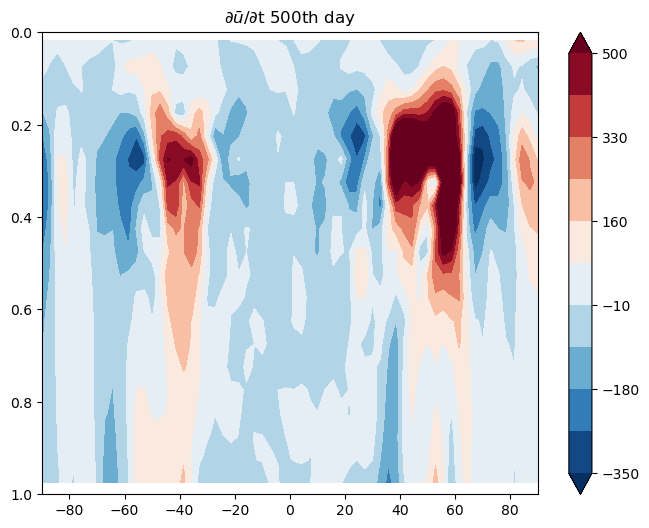

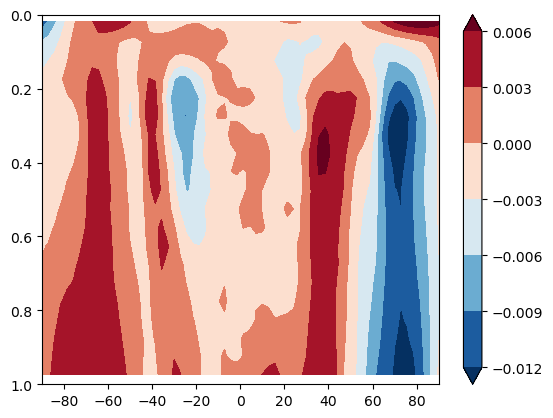

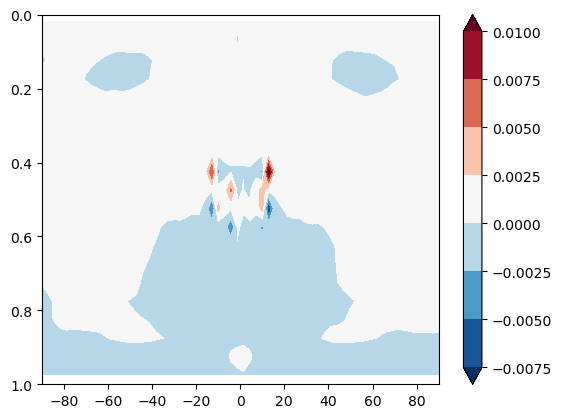

In [10]:
plt.figure(figsize=(8,6))
sigma_mean = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz = np.nanmean(sigma_mean, axis=1)
y = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
# plt.contourf(yy,sigma_mean2, np.nanmean(pupt[:,:,:],axis=0), levels=np.linspace(-350,500,11), cmap="RdBu_r", extend="both")
plt.contourf(yy,sigma_mean2, pupt[-1,:,:], levels=np.linspace(-350,500,11), cmap="RdBu_r", extend="both")

plt.ylim([1,0])
plt.colorbar()
# plt.title(r"$\partial \baru/ \partial$t time mean")
plt.title(r"$\partial \baru/ \partial$t 500th day")


plt.figure()
plt.contourf(yy, sigma_mean2, np.nanmean(Vza, axis=(0,3)), cmap="RdBu_r", extend="both")
plt.colorbar()
plt.ylim([1,0])

plt.figure()
plt.contourf(yy, sigma_mean2, f0*vTEM, cmap="RdBu_r", extend="both")
plt.colorbar()
plt.ylim([1,0])
